In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.stattools import adfuller
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

#### Load datasets

In [2]:
no_attack=pd.read_csv('BATADAL_dataset03.csv')
attack=pd.read_csv('BATADAL_dataset04.csv')
test=pd.read_csv('BATADAL_test_dataset.csv')
attack.columns = attack.columns.str.strip()
attack['DATETIME']=pd.to_datetime(attack['DATETIME'])
no_attack['DATETIME']=pd.to_datetime(no_attack['DATETIME'])
test['DATETIME']=pd.to_datetime(test['DATETIME'])
attack.set_index('DATETIME', inplace=True)
no_attack.set_index('DATETIME', inplace=True)
test.set_index('DATETIME', inplace=True)

## Function that create the ARMA model

In [3]:
def ARMA_function(train,test,test_dataset,tune_dataset,count):
    
    print('Checking if signal is stationary, if p-value is les that 0.05')
    print('  ')
    ####check stationary of signal,if p value less tha 0.05
    dftest = adfuller(train, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    print('Autocorrelation and Partial Autocorrelation Plots')
    print('  ')
    if(count==2):
        #autocorelation plots
        plot_acf(train, lags=50)
        plot_pacf(train, lags=50)
        plt.xlabel('lags')
        plt.show()
    
    print('finding optimal order')
    print('  ')
    p =range(1, 4)
    q=range(1,3)
    current_aic=np.inf
    pair_pd=None
    model=None
    for i in p:
        for j in q:
            try:
                tmp_mdl = smt.ARIMA(tune_dataset, order=(i,0,j)).fit(method='mle', trend='nc',disp=0)
                if tmp_mdl.aic < current_aic:
                    current_aic=tmp_mdl.aic
                    best_p=i
                    best_q=j
                    model=tmp_mdl
            except:
                continue
    print('The best order is')
    print(best_p,best_q)
    try:
        train_model = smt.ARIMA(train, order=(best_p,1,best_q)).fit(method='mle', trend='nc',disp=0)
        test_model = ARIMA(test, (best_p,1,best_q)).fit(start_params = train_model.params, transpars = False, method='mle', trend='nc',disp=0)
    except:
        train_model = smt.ARIMA(train, order=(best_p-1,0,best_q)).fit(method='mle', trend='nc',disp=0)
        test_model = ARIMA(test, (best_p-1,0,best_q)).fit(start_params = train_model.params, transpars = False, method='mle', trend='nc',disp=0)
    
    if (count==2):
        #plot residual error of training set
        plt.plot(train_model.resid)
        plt.title("Residual Error of sensor in training set")
        plt.show()

        #plot residual error of test set
        plt.plot(test_model.resid)
        plt.title("Residual Error of sensor in test set")
        plt.show()
    
    print('Computing the accuracy, True Positives and False Positives')
    std = np.std(train_model.resid)
    threshold = 2*std
    det_anom_lit = test_model.resid[test_model.resid > threshold]
    ind=[]
    tp=0
    fp=0
    for index, a in det_anom_lit.items():
        ind.append(index)
        if test_dataset.ATT_FLAG[index]==1:
            tp+=1
        else:
            fp+=1
    tn=test_dataset.loc[test_dataset.ATT_FLAG==-999].shape[0]-fp
    fn=test_dataset.loc[test_dataset.ATT_FLAG==1].shape[0]-tp
    Accuracy=100.0*(tp+tn)/(tp+tn+fp+fn)
    if (tp+fp)!=0:
        Precision=100.0*tp / (tp + fp)
    else:
        Precision=0
    Recall = 100.0*tp / (tp + fn)
    F_score = 100.0*2*tp /(2*tp + fp + fn)
    print ("TP:", tp)
    print ("FP:", fp)
    print("Accuracy: %.2f" % Accuracy)
    print("Precision: %.2f" % Precision)
    print("Recall: %.2f" %Recall)
    print("F_score: %.2f" % F_score)
    print('  ')
    return ind


## Creating ARMA models for sensors ['L_T1','F_PU7'] in order to produce the requested plots

In [4]:
#take specific signals
signals= ['L_T1','F_PU8']
#this variable take the number of signals that we process. Since we want to visualize Autocorrelation plots and residual
# error for just these signals, we pass this parameter in the next function.
count_for_plots=len(signals)


#######################################
('Processing sensor ', 'L_T1')
#######################################
  
Checking if signal is stationary, if p-value is les that 0.05
  
Test Statistic                  -20.615633
p-value                           0.000000
#Lags Used                       37.000000
Number of Observations Used    8723.000000
Critical Value (5%)              -2.861871
Critical Value (1%)              -3.431100
Critical Value (10%)             -2.566946
dtype: float64
Autocorrelation and Partial Autocorrelation Plots
  


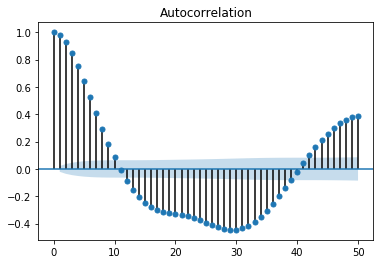

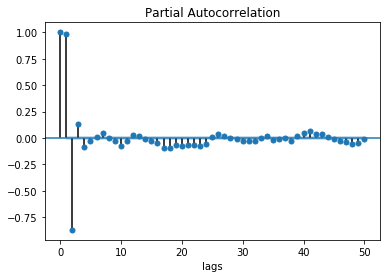

finding optimal order
  
The best order is
(3, 2)


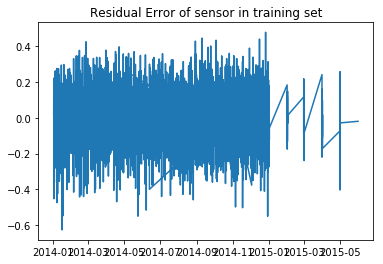

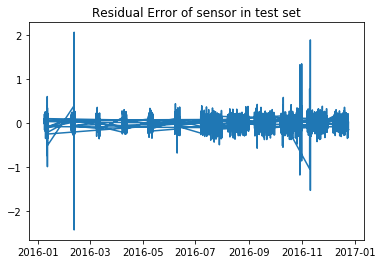

Computing the accuracy, True Positives and False Positives
('TP:', 23)
('FP:', 125)
Accuracy: 92.32
Precision: 15.54
Recall: 10.50
F_score: 12.53
  
#######################################
('Processing sensor ', 'F_PU8')
#######################################
  
Checking if signal is stationary, if p-value is les that 0.05
  
Test Statistic                -1.765701e+01
p-value                        3.697252e-30
#Lags Used                     3.700000e+01
Number of Observations Used    8.723000e+03
Critical Value (5%)           -2.861871e+00
Critical Value (1%)           -3.431100e+00
Critical Value (10%)          -2.566946e+00
dtype: float64
Autocorrelation and Partial Autocorrelation Plots
  


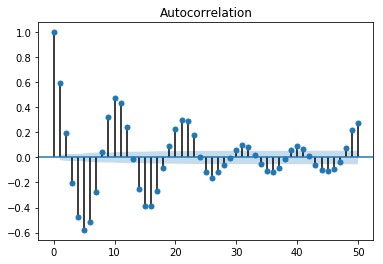

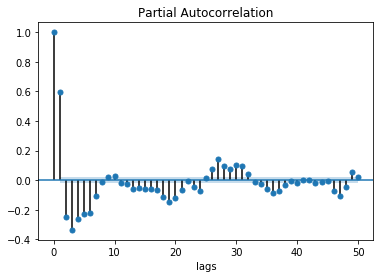

finding optimal order
  
The best order is
(1, 2)


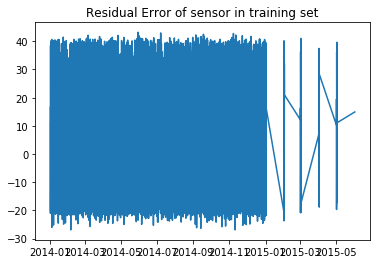

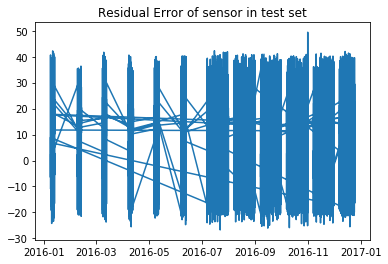

Computing the accuracy, True Positives and False Positives
('TP:', 20)
('FP:', 373)
Accuracy: 86.31
Precision: 5.09
Recall: 9.13
F_score: 6.54
  


In [5]:
total_anomalies=[]
for i in signals:
    signal1_train=no_attack[i]
    signal2_test=attack[i]
    signal1_test=test[i]
    print('#######################################')
    print('Processing sensor ',i)
    print('#######################################')
    print('  ')
    anomalies=ARMA_function(signal1_train,signal2_test,attack,signal2_test,count_for_plots)
    total_anomalies=total_anomalies+anomalies

## Creating ARMA models for many sensors using as training set the first dataset and as test the second training dataset

In [6]:
signals= ['L_T1','L_T7','L_T4','L_T3','L_T2','F_PU3','F_PU6','F_PU7','F_PU3','F_PU11','F_PU1']
# signals= ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T6', 'L_T7', 'F_PU1',
#           'S_PU1', 'F_PU2', 'F_PU3', 'F_PU4','F_PU5', 'F_PU6', 'F_PU7',
#           'F_PU8','F_PU9', 'F_PU11', 'F_V2',
#           'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J415', 
#           'P_J302', 'P_J306', 'P_J307', 'P_J317','P_J14', 'P_J422']
count_for_plots=len(signals)

In [7]:
total_anomalies=[]
for i in signals:
    signal1_train=no_attack[i]
    signal2_test=attack[i]
    signal1_test=test[i]
    print('#######################################')
    print('Processing sensor ',i)
    print('#######################################')
    print('  ')
    anomalies=ARMA_function(signal1_train,signal2_test,attack,signal2_test,count_for_plots)
    total_anomalies=total_anomalies+anomalies

#######################################
('Processing sensor ', 'L_T1')
#######################################
  
Checking if signal is stationary, if p-value is les that 0.05
  
Test Statistic                  -20.615633
p-value                           0.000000
#Lags Used                       37.000000
Number of Observations Used    8723.000000
Critical Value (5%)              -2.861871
Critical Value (1%)              -3.431100
Critical Value (10%)             -2.566946
dtype: float64
Autocorrelation and Partial Autocorrelation Plots
  
finding optimal order
  
The best order is
(3, 2)
Computing the accuracy, True Positives and False Positives
('TP:', 23)
('FP:', 125)
Accuracy: 92.32
Precision: 15.54
Recall: 10.50
F_score: 12.53
  
#######################################
('Processing sensor ', 'L_T7')
#######################################
  
Checking if signal is stationary, if p-value is les that 0.05
  
Test Statistic                -1.748971e+01
p-value                       

## Combining all individual models to create a single model for anomaly detection

In [8]:
final=[]
tot=set(total_anomalies)
for i in tot:
    if (total_anomalies.count(i)>1):
        final.append(i)
tp=0
fp=0
for i in final:
    if attack.ATT_FLAG[i]==1:
        tp+=1
    else:
        fp+=1
tn=attack.loc[attack.ATT_FLAG==-999].shape[0]-fp
fn=attack.loc[attack.ATT_FLAG==1].shape[0]-tp
Accuracy=100.0*(tp+tn)/(tp+tn+fp+fn)
if (tp+fp)!=0:
    Precision=100.0*tp / (tp + fp)
else:
    Precision=0
Recall = 100.0*tp / (tp + fn)
F_score = 100.0*2*tp /(2*tp + fp + fn)
print ("TP:", tp)
print ("FP:", fp)
print("Accuracy: %.2f" % Accuracy)
print("Precision: %.2f" % Precision)
print("Recall: %.2f" %Recall)
print("F_score: %.2f" % F_score)
print('  ')


('TP:', 9)
('FP:', 23)
Accuracy: 94.42
Precision: 28.12
Recall: 4.11
F_score: 7.17
  


## Save the predicted labels in order to be used in the comparison task

In [9]:
new_dataset=pd.read_csv('BATADAL_dataset04.csv')
new_dataset.columns = new_dataset.columns.str.strip()
new_dataset['DATETIME']=pd.to_datetime(new_dataset['DATETIME'])
new_dataset.set_index('DATETIME', inplace=True)
new_dataset.ATT_FLAG=-999
new_dataset.ATT_FLAG[final]=1


## Preprocessing in test data (adding labels based on the pdf that describe the attacks)

In [10]:
#set labels to test dataset based on the file of attacks
test['ATT_FLAG']=-999
test['ATT_FLAG']['2017-01-16 09:00:00':'2017-01-19 06:00:00']=1
test['ATT_FLAG']['2017-01-30 08:00:00':'2017-02-02 00:00:00']=1
test['ATT_FLAG']['2017-02-09 03:00:00':'2017-02-10 09:00:00']=1
test['ATT_FLAG']['2017-02-12 01:00:00':'2017-02-13 07:00:00']=1
test['ATT_FLAG']['2017-02-24 05:00:00':'2017-02-28 08:00:00']=1
test['ATT_FLAG']['2017-03-10 14:00:00':'2017-03-13 21:00:00']=1
test['ATT_FLAG']['2017-03-25 20:00:00':'2017-03-27 01:00:00']=1



## Creating ARMA models for many sensors using as training set the first dataset and as test the test dataset and the second training set was used in order to find the optimal order

In [11]:
#signals= ['L_T1','L_T7','L_T4','L_T3','L_T2','F_PU3','F_PU6','F_PU7','F_PU3','F_PU11','F_PU1']
count_for_plots=len(signals)

In [12]:
total_anomalies=[]
for i in signals:
    signal1_train=no_attack[i]
    signal2_test=attack[i]
    signal1_test=test[i]
    print('#######################################')
    print('Processing sensor ',i)
    print('#######################################')
    print('  ')
    anomalies=ARMA_function(signal1_train,signal1_test,test,signal2_test,count_for_plots)
    total_anomalies=total_anomalies+anomalies

#######################################
('Processing sensor ', 'L_T1')
#######################################
  
Checking if signal is stationary, if p-value is les that 0.05
  
Test Statistic                  -20.615633
p-value                           0.000000
#Lags Used                       37.000000
Number of Observations Used    8723.000000
Critical Value (5%)              -2.861871
Critical Value (1%)              -3.431100
Critical Value (10%)             -2.566946
dtype: float64
Autocorrelation and Partial Autocorrelation Plots
  
finding optimal order
  
The best order is
(3, 2)
Computing the accuracy, True Positives and False Positives
('TP:', 7)
('FP:', 40)
Accuracy: 85.45
Precision: 14.89
Recall: 2.58
F_score: 4.40
  
#######################################
('Processing sensor ', 'L_T7')
#######################################
  
Checking if signal is stationary, if p-value is les that 0.05
  
Test Statistic                -1.748971e+01
p-value                        4.4

## Combining all individual models to create a single model for anomaly detection

In [13]:
final=[]
tot=set(total_anomalies)
for i in tot:
    if (total_anomalies.count(i)>1):
        final.append(i)
tp=0
fp=0
for i in final:
    if test.ATT_FLAG[i]==1:
        tp+=1
    else:
        fp+=1
tn=test.loc[test.ATT_FLAG==-999].shape[0]-fp
fn=test.loc[test.ATT_FLAG==1].shape[0]-tp
Accuracy=100.0*(tp+tn)/(tp+tn+fp+fn)
if (tp+fp)!=0:
    Precision=100.0*tp / (tp + fp)
else:
    Precision=0
Recall = 100.0*tp / (tp + fn)
F_score = 100.0*2*tp /(2*tp + fp + fn)
print ("TP:", tp)
print ("FP:", fp)
print("Accuracy: %.2f" % Accuracy)
print("Precision: %.2f" % Precision)
print("Recall: %.2f" %Recall)
print("F_score: %.2f" % F_score)
print('  ')



('TP:', 2)
('FP:', 33)
Accuracy: 85.54
Precision: 5.71
Recall: 0.74
F_score: 1.31
  
